In [1]:
!pip install datasets transformers[sentencepiece]
from datasets import load_dataset
from transformers import BertTokenizer

# Load the dataset
dataset = load_dataset('squad')
print(dataset)


/home/manav/.local/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/manav/.local/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [6]:
import torchtext.vocab as vocab

embedding_dim = 200
glove = vocab.GloVe(name='6B', dim=embedding_dim)

In [2]:
max_len_context = 0
max_len_que = 0

for some in dataset['train']:
  max_len_context = max(max_len_context,(len(some['context'].split())))
  max_len_que = max(max_len_que,(len(some['question'].split())))

  # if(some['answers']['text']=='' or some['answers']['text']==None or len(some['answers']['text'])==0):
  #   print(some['answers'], " here ")
print(max_len_context, max_len_que)

653 40


In [3]:
import numpy as np
subset_indices = np.random.permutation(len(dataset['train']))

# Apply the selection
dataset["train"] = dataset['train'].select(subset_indices)

In [4]:
from transformers import AutoTokenizer

# Initialize the tokenizer from the pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

max_len = max(max_len_context, max_len_que)
max_start_pos=0
max_pos = 0
def preprocess_data(examples):
    # Tokenize the input texts and get the offsets mapping
    tokenized_inputs = tokenizer(
        examples['question'],
        examples['context'],
        truncation=True,
        max_length=max_len,
        return_offsets_mapping=True,
        return_tensors='np'  
    )

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized_inputs['offset_mapping']):
        # Initialize default positions for cases where the answer is not found
        start_token, end_token = 0, 0

        # Only proceed if an answer exists
        if examples['answers'][i]['answer_start'] and examples['answers'][i]['text']:
            start_char = examples['answers'][i]['answer_start'][0]
            end_char = start_char + len(examples['answers'][i]['text'][0])

            for idx, (offset_start, offset_end) in enumerate(offsets):
                if start_token == 0 and start_char >= offset_start and start_char < offset_end:
                    start_token = idx
                if end_char > offset_start and end_char <= offset_end:
                    end_token = idx
                    break  # Stop once the end token is found
        max_start_pos=max(end_token,max_pos)
        # print(start_token, end_token)
        start_positions.append(start_token)
        end_positions.append(end_token)

    tokenized_inputs.pop('offset_mapping')

    # Convert lists to arrays to store in the Hugging Face dataset
    tokenized_inputs['start_positions'] = np.array(start_positions)
    tokenized_inputs['end_positions'] = np.array(end_positions)

    return tokenized_inputs



# Apply the preprocessing function to the dataset
print(dataset)

tokenized_datasets = dataset.map(preprocess_data, batched=True)
print(tokenized_datasets)
print(tokenized_datasets['train']['answers'])

print(tokenized_datasets['train']['question'])


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10570
    })
})
[{'text': ['Piedigrotta'], 'answer_start': [127]}, {'text': ['after prior art has been made public'], 'answer_start': [163]}, {'text': ['public money'], 'answer_start': [832]}, {'text': ['wire protocol'], 'answer_start': [178]}, {'text': ['Fort Rosecrans'], 'answer_start': [208]}, {'text': ['559,700'], 'answer_start': [224]}, {'text': ['This was because the sanitation sector was generally receiving less attention from other donors and from governments'], 'answer_start': [592]}, {'text': ['the musical crossover phenomenon'], 'answer_start': [179]}, {'text': ['let

In [7]:
import torch
import numpy as np

vocab_size = len(tokenizer.vocab)  # Assuming you have a tokenizer
print(len(glove))
# embedding_dim = len(next(iter(glove.values())))  # Dimension of GloVe vectors
# embedding_dim = e
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))


for word, idx in tokenizer.vocab.items():
    # vector = glove.get(word)
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        # If the word is not in GloVe, initialize with random values
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))

# Convert the matrix to a torch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)
print(embedding_matrix.shape)

400000
torch.Size([30522, 200])


In [8]:
from torch.utils.data import Dataset, DataLoader

class QuestionAnsweringDataset(Dataset):
    def __init__(self, questions, contexts, start_positions, end_positions, tokenizer):
        self.questions = questions
        self.contexts = contexts
        self.start_positions = start_positions
        self.end_positions = end_positions
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        start_position = self.start_positions[idx]
        end_position = self.end_positions[idx]

        question_encodings = self.tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=max_len_que+1)
        context_encodings = self.tokenizer(context, return_tensors='pt', padding='max_length', truncation=True, max_length=max_len_context+1)

        return {
            'question_ids': question_encodings['input_ids'].squeeze(0),  # Remove batch dimension
            'question_mask': question_encodings['attention_mask'].squeeze(0),
            'context_ids': context_encodings['input_ids'].squeeze(0),
            'context_mask': context_encodings['attention_mask'].squeeze(0),
            'start_positions': torch.tensor(start_position, dtype=torch.long),
            'end_positions': torch.tensor(end_position, dtype=torch.long)
        }

# Assuming `questions`, `contexts`, `start_positions`, `end_positions` are lists containing your data
# print(tokenized_datasets)
questions = tokenized_datasets['train']['question']
contexts = tokenized_datasets['train']['context']
start_positions = tokenized_datasets['train']['start_positions']
end_positions = tokenized_datasets['train']['end_positions']

dataset = QuestionAnsweringDataset(questions, contexts, start_positions, end_positions, tokenizer)
# print(dataset[0])
# Create a DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class QuestionAnsweringModel(nn.Module):
    def __init__(self, hidden_size, vocab_size, embed_size,embedding_matrix, dropout_rate=0.2):
        super(QuestionAnsweringModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.question_bilstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.context_bilstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)

        # This layer will transform the context to have the same size as the question for attention
        self.attention_layer = nn.Linear(hidden_size * 2, hidden_size * 2)

        self.decoder_bilstm = nn.LSTM(hidden_size * 4, hidden_size, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(hidden_size * 2, 1)  # Output 2 scores for each token, start and end logits
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, question_ids, question_mask, context_ids, context_mask):
        question_embedded = self.dropout(self.embedding(question_ids))
        context_embedded = self.dropout(self.embedding(context_ids))

        # Question encoding
        packed_question = pack_padded_sequence(question_embedded, question_mask.sum(1).cpu(), batch_first=True, enforce_sorted=False)
        question_output, _ = self.question_bilstm(packed_question)
        question_output, _ = pad_packed_sequence(question_output, batch_first=True)

        # Context encoding
        packed_context = pack_padded_sequence(context_embedded, context_mask.sum(1).cpu(), batch_first=True, enforce_sorted=False)
        context_output, _ = self.context_bilstm(packed_context)
        context_output, _ = pad_packed_sequence(context_output, batch_first=True)

        # Apply attention
        attn_scores = torch.bmm(context_output, self.attention_layer(question_output).transpose(1, 2))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_question = torch.bmm(attn_weights, question_output)

        # Concatenate context and attended question for each token
        combined_output = torch.cat((context_output, attended_question), dim=-1)

        # Decode
        decoder_output_start, _ = self.decoder_bilstm(combined_output)
        decoder_output_end, _ = self.decoder_bilstm(combined_output)

        # Get start and end logits
        start_logits = self.output_layer(decoder_output_start)
        end_logits = self.output_layer(decoder_output_end)
        # print(start_logits.shape, end_logits.shape)

        # start_logits, end_logits = logits.split(1, dim=-1)

        return start_logits.squeeze(), end_logits.squeeze()

# Define sizes
hidden_size = 256
vocab_size = len(tokenizer)  # Assume tokenizer is defined elsewhere
print(vocab_size)
embed_size = embedding_dim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Initialize the model
model = QuestionAnsweringModel(hidden_size, vocab_size, embed_size, embedding_matrix=embedding_matrix).to(device)


30522


/home/manav/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
from torch.optim import Adam,SGD
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

# Prepare the DataLoader


# Initialize optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader=loader
model.train()
max_grad_norm = 1.0
num_epochs = 10
epoch_losses = []
for epoch in range(num_epochs):  # Example for 3 epochs
    epoch_loss = 0
    for batch in train_loader:
        # print(batch)
        question_ids = batch['question_ids'].to(device)
        question_mask = batch['question_mask'].to(device)
        context_ids = batch['context_ids'].to(device)
        context_mask = batch['context_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # input_ids = torch.tensor(input_ids)
        # attention_mask = torch.tensor(attention_mask)
        optimizer.zero_grad()
        # attetntion
        # print(input_ids.shape, attention_mask)
        # print(question_ids.shape, question_mask.shape, context_ids.shape, context_mask.shape)
        start_logits, end_logits = model(question_ids, question_mask, context_ids, context_mask)
        # start_logits=start_logits.T
        # end_logits=end_logits.T

        ten= torch.tensor(start_logits.shape[1]-1)
        start_positions =torch.minimum(start_positions, ten)
        start_loss = nn.CrossEntropyLoss()(start_logits, start_positions)
        ten = torch.tensor(end_logits.shape[1]-1)
        end_positions =torch.minimum(end_positions, ten)

        end_loss = nn.CrossEntropyLoss()(end_logits, end_positions)
        loss = (start_loss + end_loss)/2

        epoch_loss+=loss.item()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
    epoch_losses.append(epoch_loss)
    print(epoch,epoch_loss)




0 5.231
1 3.522
2 2.541
3 1.978
4 1.656
5 1.47
6 1.364
7 1.303
8 1.268
9 1.248


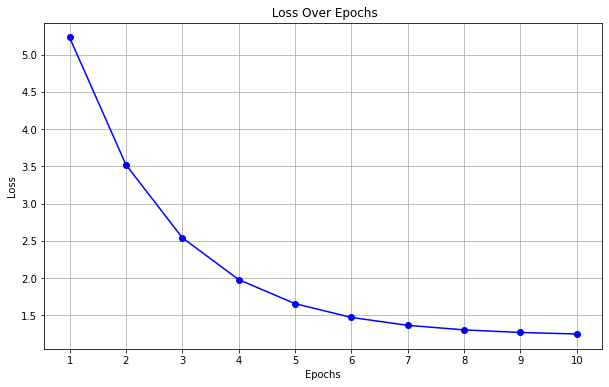

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = epoch_losses

plt.figure(figsize=(10, 6))  # Making the plot bigger
plt.plot(x, y, marker='o', linestyle='-', color='b') 
plt.title(" Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)  
plt.xticks(ticks=x)  # Set x-ticks to be exactly where we have data points
plt.show()



In [11]:
def predict_answer(model, tokenizer, dataset, device, question_max_length=max_len_que+1, context_max_length=max_len_context+1):
    model.eval()  # Put the model in evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients for predictions
        for item in dataset:
            # Separate tokenization for question and context
            question_encodings = tokenizer.encode_plus(
                item['question'],
                None,
                add_special_tokens=True,
                max_length=question_max_length,
                padding='max_length',
                return_attention_mask=True,
                truncation=True,
                return_tensors="pt"
            )

            context_encodings = tokenizer.encode_plus(
                item['context'],
                None,
                add_special_tokens=True,
                max_length=context_max_length,
                padding='max_length',
                return_attention_mask=True,
                truncation=True,
                return_tensors="pt"
            )

            # Combine inputs for the model
            inputs = {
                'question_ids': question_encodings['input_ids'].to(device),
                'question_mask': question_encodings['attention_mask'].to(device),
                'context_ids': context_encodings['input_ids'].to(device),
                'context_mask': context_encodings['attention_mask'].to(device)
            }

            # Get model predictions
            start_logits, end_logits = model(inputs['question_ids'], inputs['question_mask'], inputs['context_ids'], inputs['context_mask'])

            # Convert logits to start and end positions (assuming context_ids for the answer span)
            start_position = torch.argmax(start_logits, dim=-1).item()  # Convert to Python int
            end_position = torch.argmax(end_logits, dim=-1).item()

            # Decode the predicted answer span from the context
            answer_ids = inputs['context_ids'].squeeze().tolist()[start_position:end_position + 1]  # Adjust indexing for PyTorch tensor
            answer = tokenizer.decode(answer_ids, skip_special_tokens=True)
            print(start_position, end_position, answer, answer_ids)
            print(item['answers'])
            predictions.append(answer)

    return predictions


In [2]:
from collections import Counter

def compute_f1(predicted, truth):
    predicted_tokens = predicted.split()
    truth_tokens = truth.split()
    common_tokens = Counter(predicted_tokens) & Counter(truth_tokens)
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(predicted_tokens)
    recall = 1.0 * num_same / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_exact_match(predicted, truth):
    return int(predicted.strip() == truth.strip())

# Assume `predictions` is a list of predicted answers, and `dataset` has the ground truth
exact_matches = []
f1_scores = []

for prediction, item in zip(predictions, tokenized_datasets['train']):
    # print(item)
    ground_truths = item['answers']['text']  # Assuming this is how your dataset stores ground truth answers
    best_match = max(ground_truths, key=lambda gt: compute_f1(prediction, gt))

    exact_match = compute_exact_match(prediction, best_match)
    f1_score = compute_f1(prediction, best_match)

    exact_matches.append(exact_match)
    f1_scores.append(f1_score)

# Calculate and print the average scores
avg_exact_match = sum(exact_matches) / len(exact_matches)
avg_f1_score = sum(f1_scores) / len(f1_scores)



In [12]:

print(f"Average Exact Match on training: ", avg_exact_match)
print(f"Average F1 Score on training: ", avg_f1_score)

Average Exact Match on training:  0.532
Average F1 Score on training:  0.653


In [ ]:
exact_matches = []
f1_scores = []

for prediction, item in zip(predictions, tokenized_datasets['validation']):
    # print(item)
    ground_truths = item['answers']['text']  # Assuming this is how your dataset stores ground truth answers
    best_match = max(ground_truths, key=lambda gt: compute_f1(prediction, gt))

    exact_match = compute_exact_match(prediction, best_match)
    f1_score = compute_f1(prediction, best_match)

    exact_matches.append(exact_match)
    f1_scores.append(f1_score)

# Calculate and print the average scores
avg_exact_match = sum(exact_matches) / len(exact_matches)
avg_f1_score = sum(f1_scores) / len(f1_scores)

In [13]:
print(f"Average Exact Match on validation: ", avg_exact_match)
print(f"Average F1 Score on validation: ", avg_f1_score)

Average Exact Match on validation:  0.4432
Average F1 Score on validation:  0.5125
